# Размеры квартир

Размер = число комнат. Это нужно, чтобы более точно оценить число жителей в домах, так как число жителей в квартире по результатам переписи есть как общее (без учёта размера квартиры), так и в разбивке по числу комнат: 1, 2, 3, 4+. Данных о числе комнат по квартирам у нас нет (не нашёл), но есть данные о площади квартир по домам — можно сгруппировать площади и предположить, какому количеству комнат они соответствуют и сколько в каждом доме квартир с таким числом комнат.



In [1]:
from collections import Counter

import pandas as pd
from sklearn.cluster import MeanShift
import tqdm

pd.set_option("display.max_columns", None)

`flats.csv` — это заранее подготовленный файл со списком квартир по домам. Получен из выгрузки объектов жилищного фонда ГИС ЖКХ ( [Реестр объектов жилищного фонда](https://dom.gosuslugi.ru/#!/houses) → «Скачать») с помощью скрипта `extract_gisgkh.py`. Процесс примерно такой: скачиваем архив, извлекаем из него только Москву (несколько csv-таблиц), запускаем скрипт.

In [2]:
flats = pd.read_csv("data/flats.csv")
flats.columns = ["houseguid", "cn"]

In [3]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5152206 entries, 0 to 5152205
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   houseguid  object
 1   cn         object
dtypes: object(2)
memory usage: 78.6+ MB


In [4]:
flats.head(2)

,houseguid,cn
0,021f35f5-fe8e-4291-b7f1-48eecca62b6e,77:01:0001026:1059
1,021f35f5-fe8e-4291-b7f1-48eecca62b6e,77:01:0001026:1623


А это тот же самый реестр из открытых данных ФРТ, что использовался в геокодировании.

In [72]:
houses = pd.read_csv("data/export-reestrmkd-77-20240701.zip", sep=";", decimal=",")

In [6]:
houses.head(2)

,id,region_id,area_id,city_id,street_id,shortname_region,formalname_region,shortname_area,formalname_area,shortname_city,formalname_city,shortname_street,formalname_street,house_number,building,block,letter,address,houseguid,management_organization_id,built_year,exploitation_start_year,project_type,house_type,is_alarm,method_of_forming_overhaul_fund,floor_count_max,floor_count_min,entrance_count,elevators_count,energy_efficiency,quarters_count,living_quarters_count,unliving_quarters_count,area_total,area_residential,area_non_residential,area_common_property,area_land,parking_square,playground,sportsground,other_beautification,foundation_type,floor_type,wall_material,basement_area,chute_type,chute_count,electrical_type,electrical_entries_count,heating_type,hot_water_type,cold_water_type,sewerage_type,sewerage_cesspools_volume,gas_type,ventilation_type,firefighting_type,drainage_type
0,8649748,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,1,NaN,"г. Москва, д. 9, к. 1",521474b9-1d5a-702f-3b75-33ff10263733,7628409.0,1973.0,1973.0,П-49-04/70Д,Многоквартирный дом,Нет,На счете регионального оператора,9.0,9.0,4.0,4.0,Не присвоен,144,144.0,0.0,7219.0,4940.0,0.0,2279.0,0.0,0.0,500,500,NaN,Бетонные столбы,Железобетонные,Панельные,1159.0,На лестничной клетке,4.0,Центральное,1.0,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,Центральное,0.0,Центральное,Вытяжная вентиляция,Отсутствует,Внутренние водостоки
1,9370109,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN,1,NaN,"г. Москва, д. 14, к. 1",64f12da8-00f6-ab7c-a849-2e1c3cccd26b,NaN,NaN,NaN,NaN,Не заполнено,Нет,Не заполнено,NaN,NaN,NaN,NaN,Не заполнено,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,498,498,NaN,Не заполнено,Не заполнено,Не заполнено,NaN,Не заполнено,NaN,Не заполнено,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено


Общее поле `houseguid` позволяет объединять эти данные.

# Совпадает ли число квартир?

Так как данные из разных источников, то на всякий случай проверим, насколько хорошо они согласуются друг с другом. У нас есть `living_quarters_count` из ФРТ, а число квартир по домам из выгрузки ГИС ЖКХ мы можем посчитать самостоятельно.

In [7]:
flats_by_house = flats.groupby("houseguid").nunique().reset_index()

In [54]:
flats_by_house["cn"].value_counts().sort_index()

cn
1       35955
2         176
3         231
4         113
5         312
        ...  
2623        1
2727        1
2924        1
2996        1
3037        1
Name: count, Length: 1041, dtype: int64

1 кадастровый номер на дом — это, вероятно, индивидуальные дома. Мы их не анализируем, но на всякий случай используем при объединении данных — вдруг это многоквартирные дома, где учтена только одна квартира.

In [16]:
houses_joined = flats_by_house.merge(houses, how="right")
houses_joined.head(2)

,houseguid,cn,id,region_id,area_id,city_id,street_id,shortname_region,formalname_region,shortname_area,formalname_area,shortname_city,formalname_city,shortname_street,formalname_street,house_number,building,block,letter,address,management_organization_id,built_year,exploitation_start_year,project_type,house_type,is_alarm,method_of_forming_overhaul_fund,floor_count_max,floor_count_min,entrance_count,elevators_count,energy_efficiency,quarters_count,living_quarters_count,unliving_quarters_count,area_total,area_residential,area_non_residential,area_common_property,area_land,parking_square,playground,sportsground,other_beautification,foundation_type,floor_type,wall_material,basement_area,chute_type,chute_count,electrical_type,electrical_entries_count,heating_type,hot_water_type,cold_water_type,sewerage_type,sewerage_cesspools_volume,gas_type,ventilation_type,firefighting_type,drainage_type
0,521474b9-1d5a-702f-3b75-33ff10263733,NaN,8649748,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,1,NaN,"г. Москва, д. 9, к. 1",7628409.0,1973.0,1973.0,П-49-04/70Д,Многоквартирный дом,Нет,На счете регионального оператора,9.0,9.0,4.0,4.0,Не присвоен,144,144.0,0.0,7219.0,4940.0,0.0,2279.0,0.0,0.0,500,500,NaN,Бетонные столбы,Железобетонные,Панельные,1159.0,На лестничной клетке,4.0,Центральное,1.0,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,Центральное,0.0,Центральное,Вытяжная вентиляция,Отсутствует,Внутренние водостоки
1,64f12da8-00f6-ab7c-a849-2e1c3cccd26b,NaN,9370109,0c5b2444-70a0-4932-980c-b4dc0d3f02b5,NaN,NaN,NaN,г,Москва,NaN,NaN,NaN,NaN,NaN,NaN,14,NaN,1,NaN,"г. Москва, д. 14, к. 1",NaN,NaN,NaN,NaN,Не заполнено,Нет,Не заполнено,NaN,NaN,NaN,NaN,Не заполнено,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,498,498,NaN,Не заполнено,Не заполнено,Не заполнено,NaN,Не заполнено,NaN,Не заполнено,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено,NaN,Не заполнено,Не заполнено,Не заполнено,Не заполнено


In [17]:
houses_joined["cn"].isna().sum() / len(houses_joined)

0.0714121037463977

Около 7% домов не нашлись — странно, но ладно.

<AxesSubplot: xlabel='living_quarters_count', ylabel='cn'>

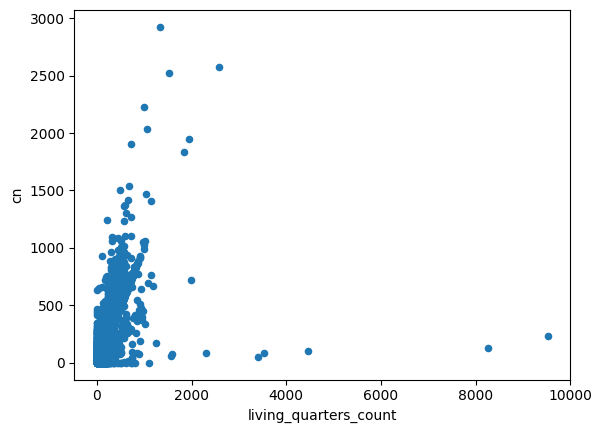

In [18]:
houses_joined.plot.scatter(x="living_quarters_count", y="cn")

In [22]:
houses_joined[["quarters_count", "living_quarters_count", "cn"]].corr()

,quarters_count,living_quarters_count,cn
quarters_count,1.000000,0.778776,0.793239
living_quarters_count,0.778776,1.000000,0.747307
cn,0.793239,0.747307,1.000000


In [21]:
houses_joined[["quarters_count", "living_quarters_count", "cn"]].corr(method="spearman")

,quarters_count,living_quarters_count,cn
quarters_count,1.000000,0.981132,0.925422
living_quarters_count,0.981132,1.000000,0.936576
cn,0.925422,0.936576,1.000000


Коэффициент ранговой корреляции выше 0.9 — ОК. По Пирсону куда меньше, но, видимо, из-за выбросов. 

In [27]:
houses_joined.assign(diff=lambda x: x["living_quarters_count"] - x["cn"])["diff"].describe()

count    31150.000000
mean        -6.375602
std         95.198999
min      -1590.000000
25%         -7.000000
50%         -3.000000
75%         -1.000000
max       9297.000000
Name: diff, dtype: float64

Не считая выбросов, кадастровых номеров обычно чуть больше, чем жилых помещений — странно, но ладно, пока не копаем глубже.

In [23]:
houses_joined[["houseguid", "address", "living_quarters_count", "cn"]].sample(10)

,houseguid,address,living_quarters_count,cn
9528,abe11a27-e7e0-45e3-8eb4-d4b4fed54824,"г. Москва, г. Зеленоград, к. 424В",144.0,149.0
9071,5ae2d412-d18e-41d1-a575-32dad9940c8e,"г. Москва, ул. Жуковского, д. 5А",27.0,32.0
22098,10de1ec1-52a3-491f-9b31-164c39635863,"г. Москва, ул. Парковая 5-я, д. 64, к. 1",69.0,71.0
18104,d9bb08e3-d2ce-4b58-96b1-2467a821531f,"г. Москва, п. Мосрентген, п. завода Мосрентген...",50.0,1.0
9480,d9d2d4fc-f6c0-407b-91f2-a7e7e9190328,"г. Москва, г. Зеленоград, к. 338А",178.0,183.0
17005,a6ffe64b-5fa8-4b46-b242-88c8b7f888d3,"г. Москва, пер. Милютинский, д. 20/2, стр. 1",67.0,102.0
29291,0303dea6-a382-4bc6-b1db-195f53e6caf9,"г. Москва, ул. Ташкентская, д. 17, к. 2",98.0,99.0
31945,02d88b70-f43a-43a9-a725-574b45d78d07,"г. Москва, ул. Цюрупы, д. 20, к. 2",72.0,73.0
3353,97967201-c946-4b5e-9225-99f941636eb9,"г. Москва, проезд. Боровский, д. 9",60.0,60.0
33907,9f5049ad-0454-4404-9fd7-c03fb56b2549,"г. Москва, ш. Энтузиастов, д. 98, к. 4",429.0,430.0


В целом выглядит не идеально, но приемлемо, особенно если учесть, что других данных у нас в общем-то и нет.

# Кластеризуем площади квартир по домам

В данных ГИС ЖКХ нет площади квартир, зато есть кадастровые номера. Площадь по кадастровым номерам есть в данных [государственной кадастровой оценки по Москве за 2023 год](https://rosreestr.gov.ru/wps/portal/p/cc_ib_portal_services/cc_ib_ais_fdgko/!ut/p/z1/lZLdTsIwFMefhQfQtkIot2PRBTA6VIT2xpRx0jTpV7rOZG9vJyZGCGw2vTk5v_9HkyKOdohb8amkiMpZodPM-PSjWE_uST4hq2Izn-JsUS7n74scY0zR9gRYE5qAbEXGpMD4mSD-P_0Z0OnxhZPhpOcnEX8b5Hc9QFexL4SlkvRiyRlGr51H5WwMTmsIiGlVxxfwLsS6WxlR18fxMS0elI4QlJW3lYggXWjfWg-I3ZBrbACh4yDSB1fBoQkwBLaN2XeNz5lSyG83IeHpB7rqJLzX7XFELIYG-mOHvVumv5i7QyIpRd5sdliVxszGvzcbjb4AEH-4GQ!!/p0/IZ7_GQ4E1C41KGUB60AIPJBVIC0080=CZ6_GQ4E1C41KGUB60AIPJBVIC0007=MEcontroller!null==/?restoreSessionState=true&action=viewProcedure&id=22543&showRep=true): «Отчет № 1/2023  составлен 22.08.2023» → «Скачать».

`flats_area.csv` — файл с площадью жилых помещений по кадастровым номерам, полученный с помощью скрипта `extract_ce.py`. Скрипт принимает на вход несколько Excel-таблиц из `1 Исходные данные.zip::1 Исходные данные/3. Сведения об ОН в перечне/2. Помещения/Помещения Жилые*`.

In [8]:
flats_area = pd.read_csv("data/flats_area.csv", index_col=0)
flats_area.columns = ["cn", "area"]
flats_area.head(2)

,cn,area
0,77:09:0001026:1674,50.8
1,77:09:0001026:1675,60.0


Нам нужен `houseguid`, так как он позволяет объединить результат с данными ФРТ.

In [9]:
flats_joined = flats.loc[
    flats["houseguid"].isin(flats_by_house.loc[flats_by_house["cn"] > 1]["houseguid"].unique())
].merge(flats_area, how="left")
flats_joined.head(2)

,houseguid,cn,area
0,021f35f5-fe8e-4291-b7f1-48eecca62b6e,77:01:0001026:1059,NaN
1,021f35f5-fe8e-4291-b7f1-48eecca62b6e,77:01:0001026:1623,86.9


In [10]:
flats_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5114501 entries, 0 to 5114500
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   houseguid  object 
 1   cn         object 
 2   area       float64
dtypes: float64(1), object(2)
memory usage: 117.1+ MB


In [11]:
flats_joined["area"].isna().sum() / len(flats_joined)

0.10550726258534313

10% пропусков — терпимо: у нас и в других местах примерно так же получалось.

Дальше будет медленно (у меня где-то два часа считалось), так как `MeanShift` — сравнительно небыстрый алгоритм. Зато хорошо (как мне кажется) группирует данные с мультимодальным распределением, которым характеризуются площади квартир по домам и не требует заранее знать число кластеров.

In [13]:
msc = MeanShift(n_jobs=3)

result = []
for label, group in tqdm.tqdm(flats_joined.groupby("houseguid")):
    na_cnt = group["area"].isna().sum()
    if na_cnt == len(group):
        continue

    try:
        msc.fit(group[["area"]].dropna())
        centers = msc.cluster_centers_
        counts = Counter(msc.labels_)
        
        for cluster_label, n_flats in counts.items():
            result.append((label, cluster_label, n_flats, centers[cluster_label][0]))
    except:
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 35120/35120 [1:40:31<00:00,  5.82it/s]


In [14]:
clusters = pd.DataFrame(result, columns=["houseguid", "cluster_label", "n_flats", "mean_area"])
clusters.head(30)

,houseguid,cluster_label,n_flats,mean_area
0,00065add-ac65-4dea-9759-285169ea505f,1,18,165.422222
1,00065add-ac65-4dea-9759-285169ea505f,0,52,117.134615
2,00065add-ac65-4dea-9759-285169ea505f,2,3,229.466667
3,00065add-ac65-4dea-9759-285169ea505f,4,2,194.400000
4,00065add-ac65-4dea-9759-285169ea505f,5,2,79.050000
5,00065add-ac65-4dea-9759-285169ea505f,3,2,273.250000
6,00095edb-6cf9-41b4-985c-bf942cf9717e,0,40,64.000000
7,00095edb-6cf9-41b4-985c-bf942cf9717e,1,30,29.806667
8,0009f2bb-b015-43c7-a166-51a33911c520,1,27,46.185185
9,0009f2bb-b015-43c7-a166-51a33911c520,0,55,36.823636


In [15]:
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128105 entries, 0 to 128104
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   houseguid      128105 non-null  object 
 1   cluster_label  128105 non-null  int64  
 2   n_flats        128105 non-null  int64  
 3   mean_area      128105 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.9+ MB


В основном у нас 3–4 кластера, что ожидаемо, так как обычно в домах будет несколько, но не слишком много вариантов квартир с разным числом комнат.

In [17]:
clusters.groupby("houseguid").size().value_counts()

3     15307
4      9983
5      4502
2      2379
6      1676
7       455
1       204
8       149
9        28
10        6
12        2
11        1
Name: count, dtype: int64

In [19]:
clusters["n_flats"].value_counts().sort_index()

n_flats
1       16902
2        5230
3        3461
4        3247
5        2915
        ...  
1083        1
1121        1
1162        1
1178        1
1384        1
Name: count, Length: 526, dtype: int64

In [25]:
clusters.loc[clusters["n_flats"] >= 10].groupby("houseguid").size().value_counts()

3    17116
2     8041
4     3944
1     2321
5      281
6       13
Name: count, dtype: int64

In [29]:
clusters["share"] = clusters["n_flats"] / clusters.groupby("houseguid")["n_flats"].transform("sum")

In [32]:
clusters.loc[clusters["share"] >= .1].groupby("houseguid").size().value_counts()

3    21394
2     8308
4     3964
1      523
5      310
6      181
7       12
Name: count, dtype: int64

Так как кластеризация медленная, то сохраним промежуточный результат.

In [23]:
clusters.to_csv("data/houses_with_flat_size_counts.csv", index=False)

# Переводим результаты кластеризации в число комнат в квартирах

Алгоритм примерно такой:
- убираем небольшие кластеры (1 квартира или меньше 10% квартир в доме);
- упорядочиваем квартиры по возрастанию площади, ранжируем. Ранг — это условное число комнат, то есть предполагаем, что квартира с наименьшим числом комнат в доме — однокомнатная;
- убираем дома с более чем 4 вариантами квартир, так как у нас все равно есть данные переписи только для 1–4 комнат и так как вариантов с 5+ кластерами после очистки результатов немного;
- корректируем число квартир так, чтобы сумма совпадала с числом комнат по данным ФРТ. Количество квартир с разным числом комнат в результате исказится и может стать даже дробным, но на это не обращаем внимание, так как в конечном итоге нам важна пропорция;
- корректируем ранг так, чтобы он более адекватно отражал число комнат, потому что однокомнатная площадью 100+ квадратных метров — это неправдоподобно (равно как и некоторые другие варианты, которые есть в `fix_n_rooms`);
- сохраняем результат для дальнейшего использования.

In [130]:
clusters = pd.read_csv("data/houses_with_flat_size_counts.csv")

In [131]:
clusters = clusters.sort_values(["houseguid", "mean_area"])

In [132]:
clusters["total_flats"] = clusters.groupby("houseguid")["n_flats"].transform("sum")
clusters["flats_share"] = clusters["n_flats"] / clusters["total_flats"]
clusters = clusters.loc[(clusters["flats_share"] >= .1) & (clusters["n_flats"] > 1)].copy()

In [133]:
clusters["n_rooms"] = clusters.groupby("houseguid")["mean_area"].rank(method="first")
clusters["n_flat_types"] = clusters.groupby("houseguid").transform("size")

In [134]:
clusters.head(20)

,houseguid,cluster_label,n_flats,mean_area,total_flats,flats_share,n_rooms,n_flat_types
1,00065add-ac65-4dea-9759-285169ea505f,0,52,117.134615,79,0.658228,1.0,2
0,00065add-ac65-4dea-9759-285169ea505f,1,18,165.422222,79,0.227848,2.0,2
7,00095edb-6cf9-41b4-985c-bf942cf9717e,1,30,29.806667,70,0.428571,1.0,2
6,00095edb-6cf9-41b4-985c-bf942cf9717e,0,40,64.000000,70,0.571429,2.0,2
9,0009f2bb-b015-43c7-a166-51a33911c520,0,55,36.823636,95,0.578947,1.0,3
8,0009f2bb-b015-43c7-a166-51a33911c520,1,27,46.185185,95,0.284211,2.0,3
10,0009f2bb-b015-43c7-a166-51a33911c520,2,13,64.253846,95,0.136842,3.0,3
12,000a0da4-73ca-4ce6-86a8-5de2ec4dcddd,0,47,32.410638,95,0.494737,1.0,3
11,000a0da4-73ca-4ce6-86a8-5de2ec4dcddd,1,35,48.734286,95,0.368421,2.0,3
13,000a0da4-73ca-4ce6-86a8-5de2ec4dcddd,2,12,66.983333,95,0.126316,3.0,3


In [135]:
clusters.groupby("houseguid").size().value_counts()

3    21229
2     8293
4     3525
1      552
5       68
6        1
Name: count, dtype: int64

In [136]:
clusters = clusters.loc[clusters["n_flat_types"] <= 4].copy()

In [137]:
clusters.groupby("houseguid").size().value_counts()

3    21229
2     8293
4     3525
1      552
Name: count, dtype: int64

In [138]:
clusters.groupby("n_rooms")["mean_area"].describe()

,count,mean,std,min,25%,50%,75%,max
n_rooms,,,,,,,,
1.0,33599.0,42.449831,23.044721,6.750000,31.844636,36.896296,45.064446,684.280000
2.0,33047.0,59.382607,28.763326,13.850000,44.489944,52.306383,64.116667,682.650000
3.0,24754.0,70.477361,27.727960,20.900000,56.350117,64.339231,75.838142,916.000000
4.0,3525.0,84.156836,28.211900,34.865217,71.762500,76.300758,93.980000,464.966667


In [139]:
clusters.sort_values("mean_area")

,houseguid,cluster_label,n_flats,mean_area,total_flats,flats_share,n_rooms,n_flat_types
70451,8b83e5ce-58da-44a8-b409-322d4433bbf3,2,2,6.750000,19,0.105263,1.0,4
119413,ee04ef42-d798-4cec-977d-008f99afba05,2,5,7.766667,24,0.208333,1.0,4
117088,e946b048-be54-4f74-ba8f-2937cd04ceee,2,7,8.212500,32,0.218750,1.0,3
15995,1f5d89b2-19f5-4833-8fd7-f3df68c94c26,3,2,8.900000,11,0.181818,1.0,4
105072,d179b4a7-475f-4499-8a2f-192ca1ed15ca,2,9,8.911111,40,0.225000,1.0,3
...,...,...,...,...,...,...,...,...
78892,9c4cbfd1-8da6-45ad-8887-c234f4c162c7,1,2,682.650000,12,0.166667,2.0,2
111029,dd170037-0b54-44d3-b7a9-9790720d5497,0,6,684.280000,8,0.750000,1.0,1
45724,5ab750f5-b5f7-4b37-bb8e-43101b025f79,2,14,700.235714,51,0.274510,3.0,3
45761,5ac95a7b-e227-4de7-b2ef-9f7fe187836f,2,2,730.800000,15,0.133333,3.0,3


In [140]:
clusters = clusters.merge(houses[["houseguid", "living_quarters_count"]].drop_duplicates("houseguid"), how="left")

In [141]:
clusters["n_flats"] = clusters["n_flats"] * clusters["living_quarters_count"].combine_first(clusters["total_flats"]) / clusters["total_flats"]
clusters["n_rooms"] = clusters["n_rooms"].astype(int)
clusters.head(2)

,houseguid,cluster_label,n_flats,mean_area,total_flats,flats_share,n_rooms,n_flat_types,living_quarters_count
0,00065add-ac65-4dea-9759-285169ea505f,0,53.316456,117.134615,79,0.658228,1,2,81.0
1,00065add-ac65-4dea-9759-285169ea505f,1,18.455696,165.422222,79,0.227848,2,2,81.0


In [142]:
clusters.groupby("houseguid").size().value_counts()

3    21229
2     8293
4     3525
1      552
Name: count, dtype: int64

In [143]:
def fix_n_rooms(group: pd.DataFrame) -> pd.DataFrame:
    mean_flat_areas = dict(zip(range(1, 5), (38, 52, 73, 90)))

    n_flat_types = group["n_flat_types"].max()
    mean_area_smallest = group.loc[group["n_rooms"] == 1.0, "mean_area"].iat[0]
    
    if n_flat_types == 3:
        if mean_area_smallest > mean_flat_areas[1]:
            group["n_rooms"] += 1
    elif n_flat_types == 2:
        area_diff = group["mean_area"].max() - group["mean_area"].min()
        if mean_area_smallest > mean_flat_areas[2]:
            group["n_rooms"] += 2
        elif mean_area_smallest > mean_flat_areas[1]:
            if area_diff < mean_area_smallest / 2:
                group["n_rooms"] += 1
            else:
                group["n_rooms"] = [2, 4]
        else:
            if area_diff < mean_area_smallest / 2:
                group["n_rooms"] += 1
            else:
                group["n_rooms"] = [1, 3]
    elif n_flat_types == 1:
        scores = [
            (n_rooms, abs(mean_flat_area - mean_area_smallest))
            for n_rooms, mean_flat_area in mean_flat_areas.items()
        ]
        group["n_rooms"] = sorted(scores, key=lambda x: x[1])[0][0]

    return group

In [145]:
clusters = clusters.groupby("houseguid").apply(fix_n_rooms).reset_index(drop=True)
clusters.head(2)

,houseguid,cluster_label,n_flats,mean_area,total_flats,flats_share,n_rooms,n_flat_types,living_quarters_count
0,00065add-ac65-4dea-9759-285169ea505f,0,53.316456,117.134615,79,0.658228,3,2,81.0
1,00065add-ac65-4dea-9759-285169ea505f,1,18.455696,165.422222,79,0.227848,4,2,81.0


In [146]:
clusters.isna().sum()

houseguid                    0
cluster_label                0
n_flats                      0
mean_area                    0
total_flats                  0
flats_share                  0
n_rooms                      0
n_flat_types                 0
living_quarters_count    10019
dtype: int64

In [147]:
clusters[["houseguid", "n_rooms", "n_flats"]].to_csv("data/flats_by_n_rooms.csv", index=False)